# Texture Synthesis Using Convolutional Neural Networks

I tried to implement this paper as faithfully as I could and I think for the most part I succeeded. One issue though, in the paper they "rescaled the weights in the network such that the mean activation of each filter over images and positions is equal to one". I couldn't work out what they meant by that so I left that step out. 

In [1]:
import torch
import os
import numpy as np
import scipy.ndimage
from torch.autograd import Variable
import torch.nn.functional as F
from torch import optim, nn
from torchvision import datasets, models, transforms
from torchvision.utils import save_image
from PIL import Image

from matplotlib import pyplot as plt

## Setting up the model

First, we download a pre-trained vgg19 model (as recommended in the paper).

In [2]:
vgg19 = models.vgg19(pretrained=True)

Load the model onto your GPU (if you have one) and "freeze" it, preventing any additional gradient updates from occurring to the already trained model. 

**Note:** I'm freezing each set of parameters individually *after* loading the model into my GPU. This is because the process of loading into the GPU destroys the old parameter tensors and creates new ones on the GPU (so freezing beforehand would have no effect).

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

vgg19 = vgg19.to(device)
for param in vgg19.features.parameters(): # stop training the net
    param.requires_grad = False

Confirm that the network really is loaded onto the GPU.

In [4]:
next(vgg19.parameters()).is_cuda # Should be `True` if you have a GPU

False

### Normalization

vgg19 expects all inputs to be normalized according to the imagenet input means and standard deviations. Un-normalized inputs will still work, but the results are less visually appealing. To help us normalize inputs we will create a custom `Normalization` layer. Everything we pass to our vgg model will go through this layer first. 

In [5]:
normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std
    
normalization_layer = Normalization(normalization_mean, normalization_std).to(device)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


Next we make a new network, using the first 38 layers from our pretrained vgg network. For texture-related purposes we don't need the rest, and removing the fully connected layers near the end means we can work with inputs of varying sizes.  

The first layer in our new network will be our custom normalization layer.

**Note:** `some_model.children()` returns an iterator containing all of the model's layers. Common practice is to turn this into a list in order to interact with it. With vgg19 what you'll actually get is a list containing two lists. The first of these contains all the layers we need.

In [6]:
useful_layers = list(list(vgg19.children())[0])
useful_layers.insert(0, normalization_layer)

vgg = nn.Sequential(*useful_layers)
print(len(list(vgg.children()))) # should be 14
list(vgg.children())

38


[Normalization(),
 Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace),
 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),

Optionally, we can also replace all the max pool layers in our vgg network with average pool layers as suggested in the paper. Personally I found that this made gradient updates a bit trickier, but it did give nicer results once I got it working.

In [7]:
vgg_layers = list(vgg.children())

for i in range(len(vgg_layers)):
    if (vgg_layers[i].__class__.__name__ == "MaxPool2d"):
        vgg_layers[i] = nn.AvgPool2d(2)

## Perpairing the example texture

The pre-trained networks from torchvision.models need to be passed inputs in a certain format, so we're going to add a transform to apply those transformations to all the image's we're dealing with. We also define a helper function `image_loader` which takes a relative image path, loads the image into a tensor, applies the relevant transformations and returns it.

`show_image` makes it easier to view images we load using `image_loader`. Pytorch doesn't seem to have any good method for visualizing tensors, so we convert the tensor to a numpy array, transpose it and then plot that using matplotlib.

**Note:** `unsqueeze()` is a pytorch function that adds extra dimensions to tensors. We're using it here because vgg19 only takes mini-batches of images, and we're working with a single image. We use `.unsqueeze()` to add the extra dimension to our image tensor and trick vgg into thinking it's dealing with a small minibatch of images. 

**Note 2:** For classification vgg19 expects input images to be normalized according to imagenet mean values. The commented out line below applies this transform. We're not doing classification though and *should not* add it here. It would cause our sample textures to be optimized to look like the *normalized* version of the example texture (i.e. off color and weird). See `data/samples/stones-normalized` for what happened to me. We can also ignore the usual size constraint of 224x224 since convolutional layers are size-agonstic and we already removed all the fully connected layers.

In [8]:
transform = transforms.Compose([
        transforms.RandomResizedCrop(400),
        transforms.ToTensor(),
    ])

def image_loader(image_path):
    image = Image.open(image_path)
    image = transform(image).float()
    image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
    return image

def show_image(image_tensor):
    np_image = image_tensor.squeeze().cpu().detach().numpy()
    plt.imshow(np.transpose(np_image, (1, 2, 0)))

Now we actually load in the image (and also plot it out).

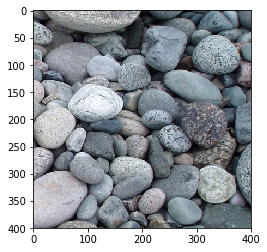

In [9]:
img_path = "data/examples/"
img_name = "stones.jpg" # we use this variable later
full_path = img_path + img_name

example_texture = image_loader(full_path)
show_image(example_texture)

## Extracting Layer activations

The guys in the paper defined the texture profile of the example texture as the **gram matrices** of the feature maps of some of the convolutional or pooling layers in vgg19 after feeding in that example texture. In order to get at these feature maps we're going to use pytorch's hook feature. 

### Hooks

Basically hooks are classes with `.hook_fn`, `.__init__` and `close` methods. `__init__` should take a layer from a module and register the hook's `hook_fn` method on that layer. Whenever the layer is run from then on, `hook_fn` for that hook instance will be called, being passed in the model holding the layer, the layer's input and the layer's output in that order. Let's ignore `close()` for now.

In this case all we want to do is save the output of each layer, so we create a simple `hook_fn` that just saves the layer's output tensor on the hook instance for later use when called.

In [10]:
class SaveFeatures():
    features=None
    def __init__(self, layer): 
        self.hook = layer.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): 
        self.features = output
    def close(self): 
        self.hook.remove()

The guys from the paper found that we don't need input from every single layer. One from each **scale** of the network (a new scale occurs when the input is down-sampled, i.e. pooling layers) seems to be enough. We register a hook instance on a convolutional or pooling layer from each scale (there are 5 scales in vgg).

In [11]:
layer_feature_maps = []

all_layers = list(vgg.children())

for index in [3, 6, 19, 26, 37]: # remember we're offsetting for the normalization layer
    layer = all_layers[index]
    layer_name = layer.__class__.__name__
    if layer_name == "Conv2d"  or layer_name == 'MaxPool2d' or layer_name == 'AvgPool2d':
        layer_feature_maps.append(SaveFeatures(layer))

print(len(layer_feature_maps)) # should be 5

5


Now we just run our network with all those conv and pooling layers already hooked, and the `.features` attributes of all our hook instances will automatically be populated with the feature maps of all those layers (as per `hook_fn`). 

In [12]:
print(type(layer_feature_maps[2].features) == type(None)) # should be True the first time you run this
vgg(example_texture)
print(layer_feature_maps[2].features[0][0][0]) # should be a tensor with random numbers in

True
tensor([ 6.4554,  8.4962,  0.2728,  9.5153, 12.8995,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  1.4302,  0.0000,  0.0000,  0.0000,  0.0000, 16.1769,
        13.0178,  8.0745,  4.0237,  7.1707,  0.0000,  0.0000,  0.0000,  8.3302,
         8.1465, 11.2701,  1.8506,  0.0000,  0.0000,  2.0782,  0.0000,  4.9261,
         5.5901,  0.0000,  0.0000, 10.7907,  6.4035,  0.0000,  6.4318,  6.8003,
         0.0000,  0.0000])


So now we have all the feature maps we need, but for texture synthesis we want to make a gram matrix for each layer's feature maps. Let's make a helper function that takes all the feature maps from a layer and returns a gram matrix. I copy-pasted this myself from somewhere random.

In [13]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d) # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

Now we have this function, let's use it to create a list of gram matrices, one for each layer we're interested in. This list represents all the summary statistics we will need from the example input. The values in this tensor will probably be tiny, or actually 0.

In [14]:
example_stats = [gram_matrix(layer.features) for layer in layer_feature_maps]
print(len(example_stats)) # should be 5
print(example_stats[0]) # should be a tensor. It will probably have very small values.

5
tensor([[1.3594e-02, 0.0000e+00, 3.0194e-03,  ..., 4.3402e-03, 1.8176e-03,
         4.5374e-03],
        [0.0000e+00, 2.6369e-10, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         7.2688e-09],
        [3.0194e-03, 0.0000e+00, 4.8277e-03,  ..., 3.3946e-03, 7.4464e-04,
         2.6710e-03],
        ...,
        [4.3402e-03, 0.0000e+00, 3.3946e-03,  ..., 1.0607e-02, 1.2074e-03,
         5.7060e-03],
        [1.8176e-03, 0.0000e+00, 7.4464e-04,  ..., 1.2074e-03, 3.2060e-03,
         2.2712e-03],
        [4.5374e-03, 7.2688e-09, 2.6710e-03,  ..., 5.7060e-03, 2.2712e-03,
         3.2072e-02]])


## Computing Loss

Next we need a way of generating a loss from the example summary statistics (above), and some sample summary statistics (which we will eventually generate by passing the sample texture through our vgg network in exactly the same way). The paper recommends calculating the **mean squared error** loss between the two sets of gram matrices.

I had a lot of trouble with this. The losses were always tiny (probably because, as above, the gram matrices I calculated from the feature maps tended to hold super small values), and often resulted in outright 0 gradients. The hacky-as-balls solution I came up with was to literally just scale the loss by some factor before returning. Gross I know.

The paper also recommends using LBFGS to perform gradient updates. `torch.optim` provides a convenience [method](https://pytorch.org/docs/stable/optim.html) for this which you should probably look up. The main takeaway is: if you're using `torch.optim.LBFGS()` as your optimizer, you can't just call `optimizer.step()` like normal. Instead, you need to pass in a special `closure()` function that calculates and returns your loss. Because we can't pass any arguments to the `closure()` function directly, we're going to create a class (`GradientStepper`) around this `closure()` function and use attribute variables on that class as parameters to our `closure()`. 

We'll also add our loss function to this class for conveniance.

In [15]:
class GradientStepper():
    def __init__(self, optimizer, model, sample_texture, layer_feature_maps, scale):
        self.optimizer = optimizer
        self.sample_texture = sample_texture
        self.model = model
        self.layer_feature_maps = layer_feature_maps
        self.scale = scale

    def loss_fn(self, stats, target_stats):
        loss = 0
        for i in range(len(target_stats)):
            loss += torch.mean((stats[i] - target_stats[i]).pow(2)) # mean squared error

        print("scale: {}".format(self.scale))
        return loss * self.scale
    
    def closure(self):
        self.optimizer.zero_grad() # Please read up on this if you don't know what it does. 

        self.model(self.sample_texture)
        sample_stats = [gram_matrix(layer.features) for layer in self.layer_feature_maps]

        loss = self.loss_fn(sample_stats, example_stats)
        loss.backward()

        print("loss: {}".format(loss))

        return loss


## Create the Sample Texture

Nearly there. Now we need to create a random image that will eventually become out sample texture. We're going to pass this texture through our vgg network and keep performing gradient descent on it against the above loss function until its summary statistics more or less match the example texture.

We use numpy to create the random image here because numpy is generally better at operating on matrices. In particular we want to smoothen the image because real life images have a natural smoothness to them.


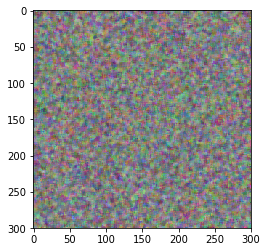

In [16]:
def random_image(blur=6, size=300):
    # create random noise numpy array
    np_sample = np.random.rand(size, size, 3)

    # smooth it out (try commenting out this line and see the difference)
    np_sample = scipy.ndimage.filters.median_filter(np_sample, [blur, blur,1]) 

    # finally convert to a tensor with autograd enabled (since we're 
    # going to be performing gradient updates on this image)
    sample = torch.from_numpy(np_sample).float().permute(2, 0, 1).unsqueeze(0).to(device) 
    sample.requires_grad = True
    
    return sample

show_image(random_image(5))

## Generate the Sample Texture

And here we are. Basically all we do now is perform an arbitrary number of gradient updates on the random sample texture. Once that's done it should look a bit like the example texture (hopefully). To make this clean and reusable, we're going to pack this process into a class called `Synthesizer`, which will take in a bunch of hyperparameters and also save the generated textures as `.jpg`'s for viewing later.

First though, we're going to define some conveniance functions.

In [17]:
def make_optimizer(name, sample_texture, lr):
    if name == "LBFGS":
        return optim.LBFGS([sample_texture], lr=0.1)
    if name == "Adam":
        return optim.Adam([sample_texture], lr=0.1) 
    
    raise ValueError('Name was not a valid optimizer identifier')

### Viewing Images

Rather than displaying the generated images here in the notebook I'm saving them to directories in this workspace. This way we can examine them at them at our leisure later. In particular I want to save a bunch of images throughout the generation process so I can observe how it's going. I'm going to give each image an "identifier", which is basically just a string representation of the hyperparameters used to generate it.


In [18]:
def identifier(params):
    id = ""
    for key in params:
        if key not in ["layer_feature_maps", "model", "iterations", "id"]:
            if key == "name":
                id += params[key].replace(".jpg", "") + "-"
            else:
                id += "{}{}-".format(key, params[key])
        
    return id[:-1]

### Synthesizer

The only important method is `synthesize`, the rest of it is just there to save the sample textures to the right directories. Basically this method takes a bunch of hyperparameters, generates a (quasi) random image, and performs gradient updates on it for a given number of iterations using the `GradientStepper` class we defined earlier.

In [19]:
class Synthesizer():
    
    sample_directory = "data/samples"
    
    def __init__(self, params):
        self.save_mode = params["save_mode"]
               
    def prepair_save_directory(self, params):
        self.identifier = params["id"]
        
        if self.save_mode == "final":
            self.dir_path = Synthesizer.sample_directory + "/finals"
            self.save_at = params["iterations"]
            
        elif self.save_mode == "throughout":
            self.dir_path = Synthesizer.sample_directory + "/" + self.identifier
            self.save_at = 1
        
        if not os.path.exists(self.dir_path):
            os.makedirs(self.dir_path)
    
    def save_path(self):
        if self.save_mode == "final":
            file_name = self.identifier
        elif self.save_mode == "throughout":
            file_name = self.save_at
        
        return "{}/{}.jpg".format(self.dir_path , file_name)
    
    def synthesize(self, params):
        sample_texture = random_image(params["blur"], params["size"])
        optimizer = make_optimizer(params["optimizer"], sample_texture, params["lr"]) 
        stepper = GradientStepper(optimizer, params["model"], sample_texture, params["layer_feature_maps"], params["scale"])
        
        self.prepair_save_directory(params)

        for i in range (params["iterations"]):
            if sample_texture.grad is not None:
                print(sample_texture.grad[0][0][0][:4])

            optimizer.step(stepper.closure)

            # occationally save an image so see how generation is going
            if (i + 1) == self.save_at:
                save_image(sample_texture, self.save_path())
                self.save_at *= 2

                if params["scale_decay"] > 0:
                    stepper.scale -= (stepper.scale / params["scale_decay"])
        
        return sample_texture

### Execution

Feel free to fiddle around with hyperparameters here, but I did a fair bit of fiddling myself, and to be honest  the only thing that seemed to make any real difference was the scale, which just needed to remain > 10,000.

In [ ]:
params = {
    "name": img_name,
    "size": 300,
    "layers": 5,
    "iterations": 128,
    "blur": 5,
    "scale_decay": 0, # 0 means no scale decay
    "scale": 100000,
    "model": vgg,
    "layer_feature_maps": layer_feature_maps,
    "optimizer": "LBFGS",
    "lr": 0.1,
}

meta_params = {
    "save_mode": "final" 
    # determine whether to save just the final image, or save at intervals while generating
}

syn = Synthesizer(meta_params)

for s in [100000]:
    for sd in [0]:
        for blur in [5, 4, 3]:
            params["scale_decay"] = sd
            params["scale"] = s
            params["blur"] = blur
            params["id"] = identifier(params) 

            print(params["id"])

            syn.synthesize(params)

stones-size300-layers5-blur5-scale_decay0-scale100000-optimizerLBFGS-lr0.1
scale: 100000
loss: 171.62103271484375
scale: 100000
loss: 171.61549377441406
scale: 100000
loss: 167.89950561523438
scale: 100000
loss: 162.51409912109375
scale: 100000
loss: 155.22784423828125
scale: 100000
loss: 146.87501525878906
scale: 100000
loss: 137.23716735839844
scale: 100000
loss: 127.98577117919922
scale: 100000
loss: 120.57504272460938
scale: 100000
loss: 114.24540710449219
scale: 100000
loss: 108.8833236694336
scale: 100000
loss: 103.81070709228516
scale: 100000
loss: 98.81558227539062
scale: 100000
loss: 94.10140228271484
scale: 100000
loss: 89.48334503173828
scale: 100000
loss: 84.85838317871094
scale: 100000
loss: 80.18695831298828
scale: 100000
loss: 75.79794311523438
scale: 100000
loss: 71.66978454589844
scale: 100000
loss: 67.81187438964844
tensor([ 0.0018, -0.0035, -0.0244,  0.0218])
scale: 100000
loss: 64.39751434326172
scale: 100000
loss: 61.17523193359375
scale: 100000
loss: 58.3120269775

scale: 100000
loss: 0.6217517852783203
scale: 100000
loss: 0.6163449287414551
tensor([-4.6942e-05, -1.0403e-04, -6.3599e-05,  2.6722e-05])
scale: 100000
loss: 0.6107345819473267
scale: 100000
loss: 0.6050885319709778
scale: 100000
loss: 0.5990308523178101
scale: 100000
loss: 0.5929378867149353
scale: 100000
loss: 0.5872471332550049
scale: 100000
loss: 0.5816447138786316
scale: 100000
loss: 0.575731098651886
scale: 100000
loss: 0.5705135464668274
scale: 100000
loss: 0.5647232532501221
scale: 100000
loss: 0.5594378709793091
scale: 100000
loss: 0.5540580153465271
scale: 100000
loss: 0.5487306118011475
scale: 100000
loss: 0.5441641211509705
scale: 100000
loss: 0.5399640798568726
scale: 100000
loss: 0.5350183844566345
scale: 100000
loss: 0.5305618047714233
scale: 100000
loss: 0.5261397361755371
scale: 100000
loss: 0.5213946104049683
scale: 100000
loss: 0.516482949256897
scale: 100000
loss: 0.5118528604507446
tensor([1.0678e-04, 5.9123e-05, 2.3540e-05, 8.1174e-05])
scale: 100000
loss: 0.5071

scale: 100000
loss: 0.2114793211221695
scale: 100000
loss: 0.21085163950920105
scale: 100000
loss: 0.2102007120847702
scale: 100000
loss: 0.20956319570541382
scale: 100000
loss: 0.2089504450559616
scale: 100000
loss: 0.20832344889640808
scale: 100000
loss: 0.20764891803264618
scale: 100000
loss: 0.20702898502349854
scale: 100000
loss: 0.20640666782855988
tensor([ 1.5243e-05, -2.1275e-05, -5.3463e-06, -2.7375e-05])
scale: 100000
loss: 0.20580992102622986
scale: 100000
loss: 0.20512397587299347
scale: 100000
loss: 0.20444878935813904
scale: 100000
loss: 0.20382140576839447
scale: 100000
loss: 0.20321442186832428
scale: 100000
loss: 0.20261730253696442
scale: 100000
loss: 0.20197251439094543
scale: 100000
loss: 0.2013021856546402
scale: 100000
loss: 0.20066171884536743
scale: 100000
loss: 0.20010845363140106
scale: 100000
loss: 0.19959081709384918
scale: 100000
loss: 0.19895800948143005
scale: 100000
loss: 0.1983555257320404
scale: 100000
loss: 0.19779005646705627
scale: 100000
loss: 0.19

loss: 0.13479481637477875
scale: 100000
loss: 0.13456213474273682
scale: 100000
loss: 0.13432297110557556
scale: 100000
loss: 0.13408829271793365
scale: 100000
loss: 0.13385193049907684
scale: 100000
loss: 0.1336236149072647
scale: 100000
loss: 0.13341471552848816
scale: 100000
loss: 0.1331688016653061
scale: 100000
loss: 0.1329403817653656
scale: 100000
loss: 0.13271579146385193
scale: 100000
loss: 0.1324911266565323
scale: 100000
loss: 0.13228948414325714
scale: 100000
loss: 0.1320856362581253
scale: 100000
loss: 0.13187424838542938
scale: 100000
loss: 0.1316525638103485
scale: 100000
loss: 0.1314120888710022
scale: 100000
loss: 0.13118615746498108
scale: 100000
loss: 0.13098402321338654
tensor([ 2.0169e-05,  9.6632e-06, -8.8248e-06,  5.1582e-06])
scale: 100000
loss: 0.13077014684677124
scale: 100000
loss: 0.1305529922246933
scale: 100000
loss: 0.13032814860343933
scale: 100000
loss: 0.13009972870349884
scale: 100000
loss: 0.1298774629831314
scale: 100000
loss: 0.1296558380126953
sca

scale: 100000
loss: 0.10372217744588852
scale: 100000
loss: 0.10360695421695709
scale: 100000
loss: 0.10349059849977493
scale: 100000
loss: 0.10336726903915405
scale: 100000
loss: 0.10325010120868683
tensor([-1.4647e-05, -1.7989e-05,  7.7370e-06, -8.2065e-06])
scale: 100000
loss: 0.10313761979341507
scale: 100000
loss: 0.1030173972249031
scale: 100000
loss: 0.1028948426246643
scale: 100000
loss: 0.10278306156396866
scale: 100000
loss: 0.10267909616231918
scale: 100000
loss: 0.10256284475326538
scale: 100000
loss: 0.10245000571012497
scale: 100000
loss: 0.10233332216739655
scale: 100000
loss: 0.10222654789686203
scale: 100000
loss: 0.1021185964345932
scale: 100000
loss: 0.1020144522190094
scale: 100000
loss: 0.10191786289215088
